## Metric 4: Number of Smoke Waves Each Year
We defined smoke waves as the number of instances of 2 consecutive days over 12 μg/m3 wildfire PM2.5

In [1]:
import numpy as np
import numpy.ma as ma
import os
from datetime import datetime, timedelta 
import csv
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs

In [2]:
current_directory = os.path.dirname(os.getcwd())

In [3]:
# Number of Smoke Waves
relative_path = "Output/WFS_M4_smoke_waves.csv"
grouped_data_path = os.path.join(current_directory, relative_path)
smoke_waves = pd.read_csv(grouped_data_path)

# Census Tracts Shapefile
relative_sf_path = "Raw_Data/Shapefiles/Tracts2020.shp"
grouped_data_CT_path = os.path.join(current_directory, relative_sf_path)
Tracts2020 = gpd.read_file(grouped_data_CT_path)
Tracts2020 = Tracts2020.to_crs(epsg=3338) # NAD AK Albers projection (better to project maps of AK only)

# Maps Output Folder Path
output_folder = os.path.join(current_directory, "Output")

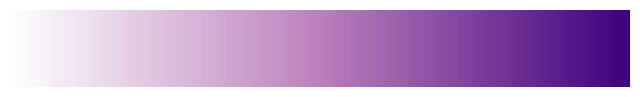

In [4]:
# Define colors: White -> Bright Purple -> Deep Dark Purple
colors = ["white", "#BC80BD", "#3F007D"]  # Midpoint = Bright Purple, Endpoint = Dark Purple
WhiteToPurple = mcolors.LinearSegmentedColormap.from_list("WhiteToPurple", colors)

# Test the colormap with a gradient
gradient = np.linspace(0, 1, 256).reshape(1, -1)

fig, ax = plt.subplots(figsize=(8, 1))
ax.imshow(gradient, aspect="auto", cmap=WhiteToPurple)
ax.set_axis_off()
plt.show()

## Cumulative Map

In [5]:
# Merge the data based on the common column
merged_data = Tracts2020.merge(smoke_waves, left_on='NAME', right_on='NAME', how='inner')
merged_data.head()

,NAME,STATE,BOROUGH,TRACT,FIPS,TOTALPOP,WHITE,BLACK,NATIVE,ASIAN,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,.groups.x
0,Saxman/Mountain Point,02,130,000400,02130000400,2374.0,1546.0,10.0,439.0,43.0,...,0,0,0,0,1,0,0,0,0,drop
1,South Lakes,02,170,001004,02170001004,5182.0,4140.0,60.0,252.0,66.0,...,0,0,2,1,0,0,0,6,0,drop
2,West Meadow Lakes,02,170,000701,02170000701,3830.0,2965.0,51.0,222.0,36.0,...,0,0,2,2,0,0,0,5,0,drop
3,Talkeetna,02,170,000102,02170000102,2607.0,2230.0,4.0,84.0,24.0,...,0,0,2,3,0,0,0,5,0,drop
4,Knik Arm,02,170,000604,02170000604,7470.0,5128.0,182.0,959.0,133.0,...,0,0,2,1,0,0,0,7,0,drop


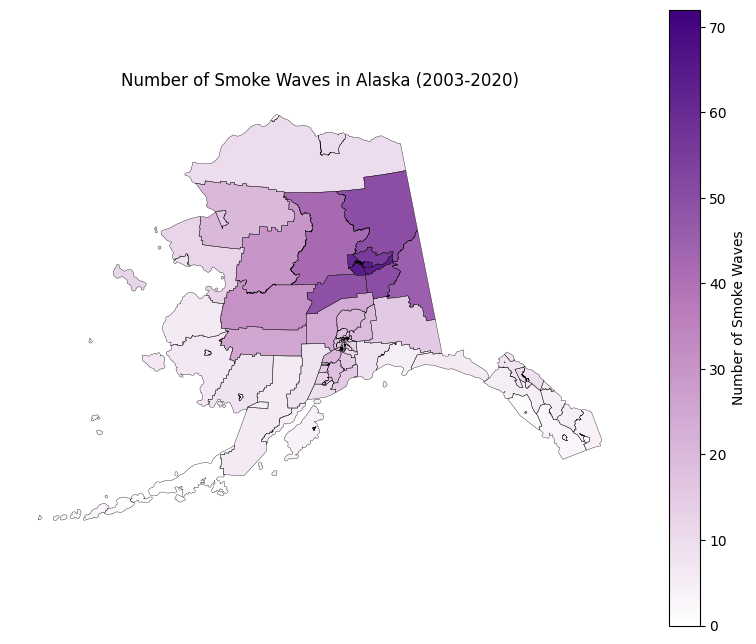

In [6]:
# Create a figure and GeoAxes with the Albers Equal Area projection
alaska_albers = ccrs.AlbersEqualArea(central_longitude=-152, central_latitude=50)
fig, ax = plt.subplots(subplot_kw={'projection': alaska_albers}, figsize=(10, 8))

# Add thin black border to the shapefile data
merged_data.boundary.plot(ax=ax, color='black', linewidth=0.25, transform=alaska_albers)

vmin = 0
vmax = merged_data['Total_Smoke_Waves'].max()

# Plot the shapefile data with a custom legend title
merged_data.plot(
    ax=ax,
    column='Total_Smoke_Waves',
    cmap=WhiteToPurple,
    transform=alaska_albers,
    legend=True,
    vmin=vmin,
    vmax=vmax,
    legend_kwds={'label': "Number of Smoke Waves", 'orientation': "vertical"}  # Add legend title and orientation
)

# Remove square
fig, ax = plt.gcf(), plt.gca()
ax.axis('off')

# Export without title
wfs_m4_cumul_relative_path = "Output/WFS_M4_Cumulative_Map.png"
wfs_m4_cumul_path = os.path.join(current_directory, wfs_m4_cumul_relative_path)
plt.savefig(wfs_m4_cumul_path, dpi=300, bbox_inches='tight')

# Map title
ax.set_title("Number of Smoke Waves in Alaska (2003-2020)")

# Export with title
wfs_m4_cumul_relative_path = "Output/WFS_M4_Cumulative_Map_Titled.png"
wfs_m4_cumul_path = os.path.join(current_directory, wfs_m4_cumul_relative_path)
plt.savefig(wfs_m4_cumul_path, dpi=300, bbox_inches='tight')

plt.show()
plt.close()

## Panel Map

Saving figure...
Figure saved successfully!


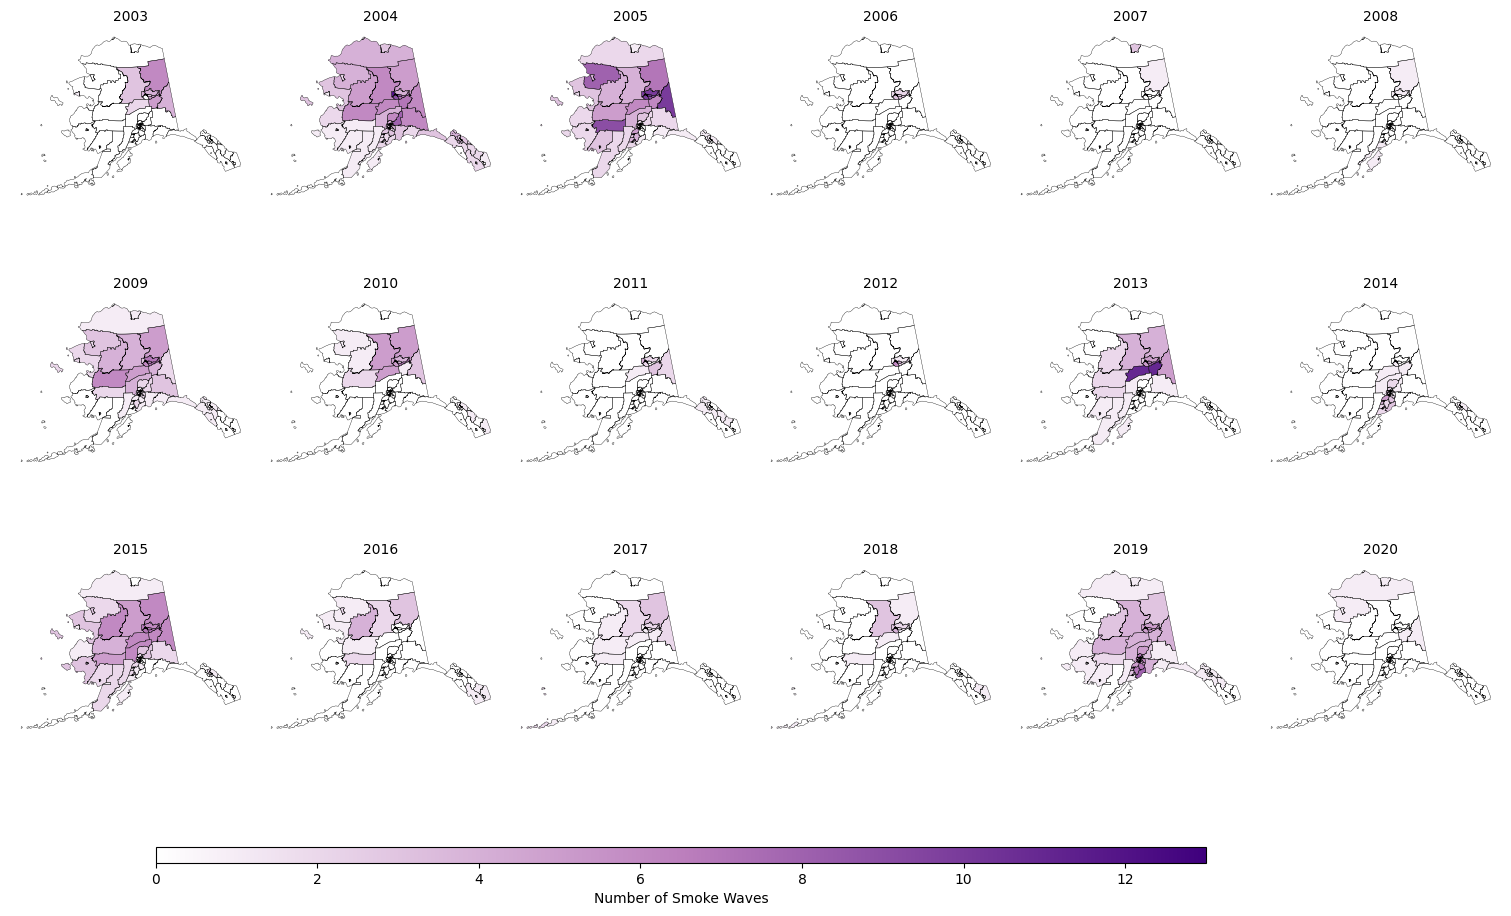

In [8]:
alaska_albers = ccrs.AlbersEqualArea(central_longitude=-152, central_latitude=50)

# Define the range of years you want to plot
years = range(2003, 2021) 

# Create a figure with multiple subplots arranged in a grid
n_cols = 6
n_rows = 3
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, subplot_kw={'projection': alaska_albers}, figsize=(15, 8), constrained_layout=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Select only columns that are years (e.g., 2003 to 2020)
year_columns = [col for col in merged_data.columns if col.isdigit() and 2003 <= int(col) <= 2020]

# Calculate the maximum value across the selected year columns
max_value = merged_data[year_columns].max().max()

# Define color scale based on your chosen minimum and maximum values
vmin = 0
vmax = max_value

# Iterate over each year
for i, year in enumerate(years):
    merged_data.boundary.plot(ax=axes[i], color='black', linewidth=0.25, transform=alaska_albers)
    merged_data.plot(
        ax=axes[i],
        column=str(year),
        cmap=WhiteToPurple,
        transform=alaska_albers,
        legend=False,
        vmin=vmin,
        vmax=vmax,
        edgecolor='none'
    )

    # Set the title for each subplot
    axes[i].set_title(f"{year}", fontsize=10)

    # Remove axis ticks and labels for a cleaner look
    axes[i].axis('off')

# Hide any unused axes if the number of years is less than the grid size
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

# Add a single color bar for the entire figure
cbar_ax = fig.add_axes([0.1, -0.1, 0.7, 0.02])
sm = plt.cm.ScalarMappable(cmap=WhiteToPurple, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', label="Number of Smoke Waves")

# Define the output path and save the figure
output_file_path = os.path.join(output_folder, "WFS_M4_Panel.png")

print("Saving figure...")
plt.savefig(output_file_path, dpi=300, bbox_inches='tight')
print("Figure saved successfully!")
plt.show()
plt.close()

## Annual Maps

In [32]:
# Define the Albers Equal Area projection for Alaska
alaska_albers = ccrs.AlbersEqualArea(central_longitude=-152, central_latitude=50)

# Generate tick positions for colorbar
ticks = np.linspace(vmin, vmax, num=5)

# Ensure all column names are strings
merged_data.columns = merged_data.columns.astype(str)

# Define min and max values for color scaling across all plots
vmin = 0
vmax = max_value

# Iterate over each year
for year in years:
    # Prepare the data for the current year
    temp_data = pd.DataFrame({
        'NAME': merged_data['NAME'],
         'Smoke_Wave_Data': merged_data[str(year)]
    })

    year_specific_data = Tracts2020.merge(temp_data, on='NAME', how='inner')
    
    # Create a new figure for each year
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': alaska_albers}, figsize=(10, 8))
    
    # Add thin black border to the shapefile data
    merged_data.boundary.plot(ax=ax, color='black', linewidth=0.10, transform=alaska_albers)

    # Plot the shapefile with color based on Days_Above_9 values
    year_specific_data.plot(
        ax=ax,
        column='Smoke_Wave_Data',  # Dynamically use the data column
        cmap=WhiteToPurple,
        transform=alaska_albers,
        legend=False,
        vmin=vmin,
        vmax=vmax,
        edgecolor='none'
    )

    # Add a colorbar for the individual map
    cbar = fig.colorbar(
        plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=WhiteToPurple),
        ax=ax,
        orientation='horizontal',
        fraction=0.046, pad=0.04, ticks=ticks
    )
    cbar.set_label("Number of Smoke Waves") 

    # Set the title for the map
    ax.set_title(f"WFS M4: Number of Smoke Waves - {year}", fontsize=14)

    # Remove axes ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')  # Remove the frame

    # Save the individual map to the output folder
    output_file_path = f"{output_folder}/WFS_M4_{year}.png"
    plt.savefig(output_file_path, dpi=600, bbox_inches='tight')
    
    # Close the figure to release memory
    plt.close(fig)

print("All individual maps have been saved to:", output_folder)

All individual maps have been saved to: /mnt/c/Users/nrathauda/OneDrive - University of Alaska/NIMHD K01 - wildfire and birth outcomes/Wildfire_and_Birth_Outcomes/4. Wildfire Smoke Metrics/Output/Maps/WFS_Metric_4
